In [1]:
from pathlib import Path
import json
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, mean_absolute_percentage_error

from models.vanilla_nn_bands_only import NNBandsOnly
from models.nn_aux_vars import NNAuxAndBands
from src.data_utils import LabelledTraitData

In [2]:
dpath = Path('/Users/campbelli/Documents/geofm-plant-traits/data')
var = 'Dry.mass.g'

In [3]:
metadata_path = dpath / 'metadata/trait_stats.json'
with open(metadata_path, 'r') as f:
    trait_stats = json.load(f)

In [4]:
# Load model, data and trait stats.
model = NNAuxAndBands(seed=42, var=var)
dataset = LabelledTraitData(dpath, var)
model.set_stats(trait_stats[var])

X_train, y_train = dataset.train_data, dataset.train_labels
X_test, y_test = dataset.test_data, dataset.test_labels
X_val, y_val = dataset.val_data, dataset.val_labels

X_train, y_train = model.configure_data(X_train, y_train)
X_test, y_test = model.configure_data(X_test, y_test)
X_val, y_val = model.configure_data(X_val, y_val)

In [5]:
model.fit(X_train, y_train, X_val, y_val)

Epoch 0, Loss: 1.0089409351348877, MAPE: 0.5649622970569151
Epoch 5, Loss: 0.9531590938568115, MAPE: 0.5544511918191054
Epoch 10, Loss: 0.9085673093795776, MAPE: 0.5091345695890406
Epoch 15, Loss: 0.9029182195663452, MAPE: 0.5221770283104454
Epoch 20, Loss: 0.946986198425293, MAPE: 0.5592680942927865
Epoch 25, Loss: 1.025957465171814, MAPE: 0.619270168716546
Epoch 30, Loss: 1.0040881633758545, MAPE: 0.5969332721207056
Epoch 35, Loss: 1.0032886266708374, MAPE: 0.5937915090084611
Epoch 40, Loss: 1.0603692531585693, MAPE: 0.6332174299584902
Epoch 45, Loss: 1.0063241720199585, MAPE: 0.5950234722010939
Epoch 50, Loss: 0.9761194586753845, MAPE: 0.5741807486495407
Epoch 55, Loss: 0.9847967028617859, MAPE: 0.5795961164070478
Epoch 60, Loss: 0.9725416898727417, MAPE: 0.5742496333892222
Epoch 65, Loss: 0.9899217486381531, MAPE: 0.5878400765975932
Epoch 70, Loss: 0.9535947442054749, MAPE: 0.5604995464032142
Epoch 75, Loss: 0.9559732675552368, MAPE: 0.5645944637891652
Epoch 80, Loss: 1.00553619861

NNAuxAndBands(seed=42, var='Dry.mass.g')

In [6]:
def get_activations(model, X):
    activations = []
    hooks = []

    # Register hooks to capture activations
    for layer in model.model.children():
        if isinstance(layer, nn.Linear): # for fully-connected layers only
            # Register a forward hook to capture the output
            # of the layer
            hooks.append(layer.register_forward_hook(lambda m, i, o: activations.append(o.detach())))

    # Forward pass
    with torch.no_grad():
        model.model(X)

    # Remove hooks from layers
    for hook in hooks:
        hook.remove()

    return activations

# Retrieve activations for test data
activations = get_activations(model, X_test)

# Check for dead neurons
for i, activation in enumerate(activations):
    dead_neurons = (activation == 0).all(dim=0)
    print(f"Layer {i}: {dead_neurons.sum().item()} dead neurons")

Layer 0: 0 dead neurons
Layer 1: 0 dead neurons
Layer 2: 0 dead neurons
Layer 3: 0 dead neurons
Layer 4: 0 dead neurons
Layer 5: 0 dead neurons


In [7]:
# Evaluate model
y_pred = model.predict(X_test)

y_pred, y_test = model.unstandardise(y_pred, y_test)

metrics = {
    # Calculate metrics.
    "R_squared": r2_score(y_test, y_pred),
    "RMSE": root_mean_squared_error(y_test, y_pred),
    "MAE": mean_absolute_error(y_test, y_pred),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred) * 100,
}

In [8]:
metrics

{'R_squared': 0.09908717132185507,
 'RMSE': 0.9781059227005049,
 'MAE': 0.6692121464187178,
 'MAPE': 80.28885841520757}

In [9]:
VARS = [
    'N.Percent',
    'P.Percent',
    'K.Percent',
    'Ca.Percent',
    'Mg.Percent',
    'C.Percent',
    'Amax',
    'Asat',
    'Area.cm2',
    'Dry.mass.g',
    'Fresh.mass.g',
    'Thickness.mm',
    'SLA.g.m2'
]

In [50]:
l2_reg = 0.0
two_layer_model = nn.Sequential(
    nn.Linear(26, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
)

In [51]:
model_weights = {}
activations = {}
predictions = {}
true_vals = {}
residuals = {}
metrics = {}

for var in VARS:
    model = NNAuxAndBands(seed=42, var=var)
    model.model = two_layer_model
    model.optimizer = torch.optim.Adam(model.model.parameters(), lr=1e-3, weight_decay=l2_reg)
    dataset = LabelledTraitData(dpath, var)
    model.set_stats(trait_stats[var])

    X_train, y_train = dataset.train_data, dataset.train_labels
    X_test, y_test = dataset.test_data, dataset.test_labels
    X_val, y_val = dataset.val_data, dataset.val_labels

    X_train, y_train = model.configure_data(X_train, y_train)
    X_test, y_test = model.configure_data(X_test, y_test)
    X_val, y_val = model.configure_data(X_val, y_val)

    model.fit(X_train, y_train, X_val, y_val)
    model_weights[var] = model.model.state_dict()
    activations[var] = get_activations(model, X_test)

    y_pred = model.predict(X_test)

    if type(y_pred) != np.ndarray:
        y_pred = y_pred.numpy().flatten()
        y_test = y_test.numpy().flatten()

    predictions[var] = y_pred
    true_vals[var] = y_test
    residuals[var] = y_test - y_pred

    y_pred, y_test = model.unstandardise(y_pred, y_test)

    # Calculate metrics.
    metrics[var] = {
        "R_squared": r2_score(y_test, y_pred),
        "RMSE": root_mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "MAPE": mean_absolute_percentage_error(y_test, y_pred) * 100,
    }

Epoch 0, Loss: 0.4724162518978119, MAPE: 0.12792759358442168
Epoch 5, Loss: 0.3654960095882416, MAPE: 0.11045398945039792
Epoch 10, Loss: 0.37909698486328125, MAPE: 0.11152232295611282
Epoch 15, Loss: 0.36979103088378906, MAPE: 0.11151640652611473
Epoch 20, Loss: 0.3775589168071747, MAPE: 0.11030283759708591
Epoch 25, Loss: 0.3906959891319275, MAPE: 0.11474267658057798
Epoch 30, Loss: 0.37816286087036133, MAPE: 0.11076444367778623
Epoch 35, Loss: 0.37042683362960815, MAPE: 0.1105623864387277
Epoch 40, Loss: 0.3713739812374115, MAPE: 0.10997629799964749
Epoch 45, Loss: 0.3848941922187805, MAPE: 0.11359067898518055
Epoch 50, Loss: 0.39050406217575073, MAPE: 0.11760131316101563
Epoch 55, Loss: 0.3971293866634369, MAPE: 0.1122033875338607
Epoch 60, Loss: 0.39875873923301697, MAPE: 0.11495108232217217
Epoch 65, Loss: 0.38680779933929443, MAPE: 0.11611567201292798
Epoch 70, Loss: 0.4010952115058899, MAPE: 0.114500669132059
Epoch 75, Loss: 0.40579953789711, MAPE: 0.1142045990214455
Epoch 80, 

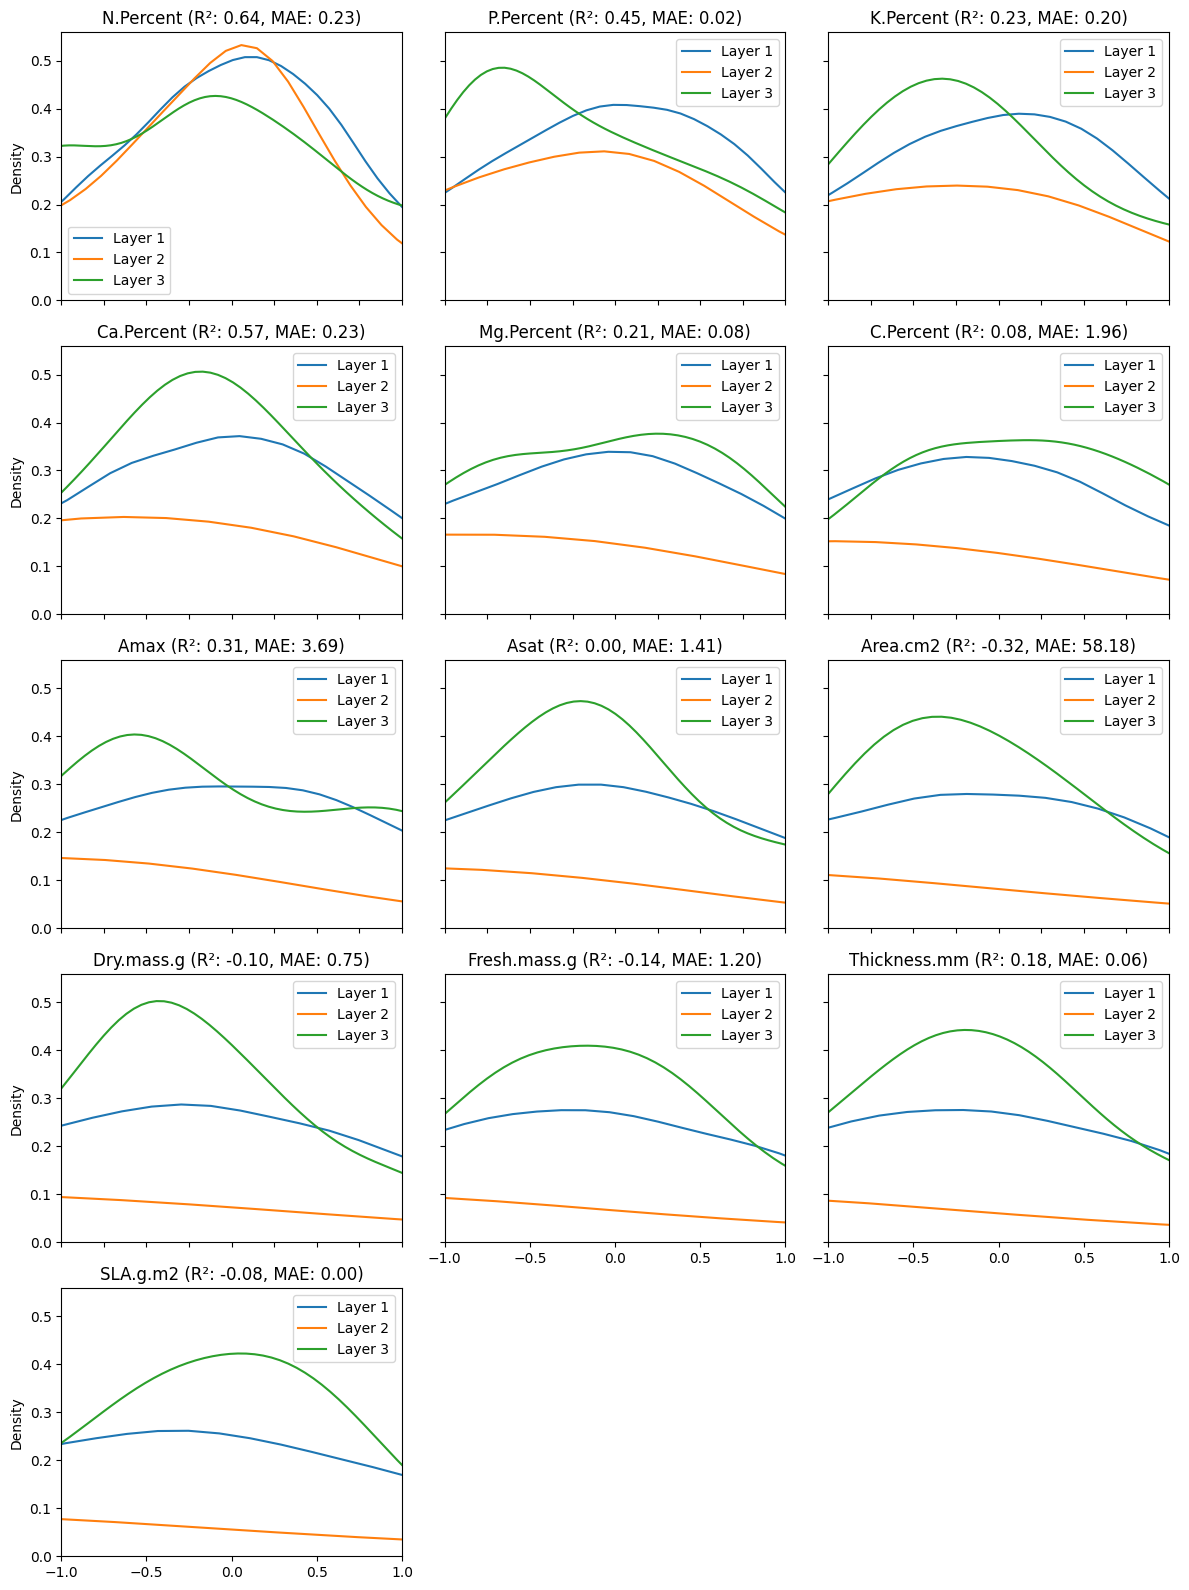

In [52]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 16), sharey=True)

# remove empty subplots
for j in range(len(VARS), len(axes.flat)):
    axes.flat[j].remove()

for var in VARS:
    ax = axes.flat[VARS.index(var)]
    r_squared = metrics[var]['R_squared']
    mae = metrics[var]['MAE']

    for i, layer in enumerate(activations[var]):
        sns.kdeplot(layer.flatten().numpy(), ax=ax, label=f'Layer {i+1}', fill=False)

    ax.set_xlim(-1, 1)
    ax.set_title(f"{var} (R²: {r_squared:.2f}, MAE: {mae:.2f})")
    ax.legend()

    i = VARS.index(var)
    
    # Set labels for last subplots in column.
    if i > 9:
        # ax.set_xlabel("Predicted values")
        ax.set_xticks([-1, -0.5, 0, 0.5, 1])
    else:
        ax.set_xticklabels([])

# Space subplots
plt.subplots_adjust(hspace=0.2, wspace=0.1)

plt.savefig(f'../figures/models/activations_nnauxvars_regularisation_2layer_{l2_reg}.png', dpi=300, bbox_inches='tight')
plt.tight_layout()

In [53]:
def qqplot(y, preds, ax, metrics, var):
    """Create a QQ plot of true vs predicted values."""
    minmax = 2.5
    r_squared = metrics['R_squared']
    mae = metrics['MAE']

    quantiles = np.linspace(0.01, 0.99, 50, endpoint=True)
    y_q = np.quantile(y, quantiles)
    preds_q = np.quantile(preds, quantiles)

    sns.scatterplot(x=y_q, y=preds_q, ax=ax, alpha=0.8, s=24)
    ax.plot([-minmax, minmax], [-minmax, minmax], color='grey', linestyle='--')
    ax.set_title(f"{var} (R²: {r_squared:.2f}, MAE: {mae:.2f})")
    ax.set_ylim(-minmax, minmax)
    ax.set_xlim(-minmax, minmax)

    # Set labels for last subplots in column.
    if i > 9:
        ax.set_xlabel("True quantiles")
        ax.set_xticks([-2, -1, 0, 1, 2])
    else:
        ax.set_xticklabels([])

    if i % 3 == 0:
        ax.set_ylabel("Predicted quantiles")
    else:
        ax.set_yticklabels([])

def plot_residuals(residuals, preds, ax, metrics, var):
    """Plot residuals vs predicted values."""
    r_squared = metrics['R_squared']
    mae = metrics['MAE']
    i = VARS.index(var)

    sns.scatterplot(x=preds, y=residuals, ax=ax, alpha=0.5, s=24)

    ax.set_title(f"{var} (R²: {r_squared:.2f}, MAE: {mae:.2f})")
    ax.set_ylim(-2., 2.)
    ax.set_xlim(-3.5, 3.5)

    # Set labels for last subplots in column.
    if i > 9:
        ax.set_xlabel("Predicted values")
        ax.set_xticks([-3, -2, -1, 0, 1, 2, 3])
    else:
        ax.set_xticklabels([])

    if i % 3 == 0:
        ax.set_ylabel("Residuals")
    else:
        ax.set_yticklabels([])

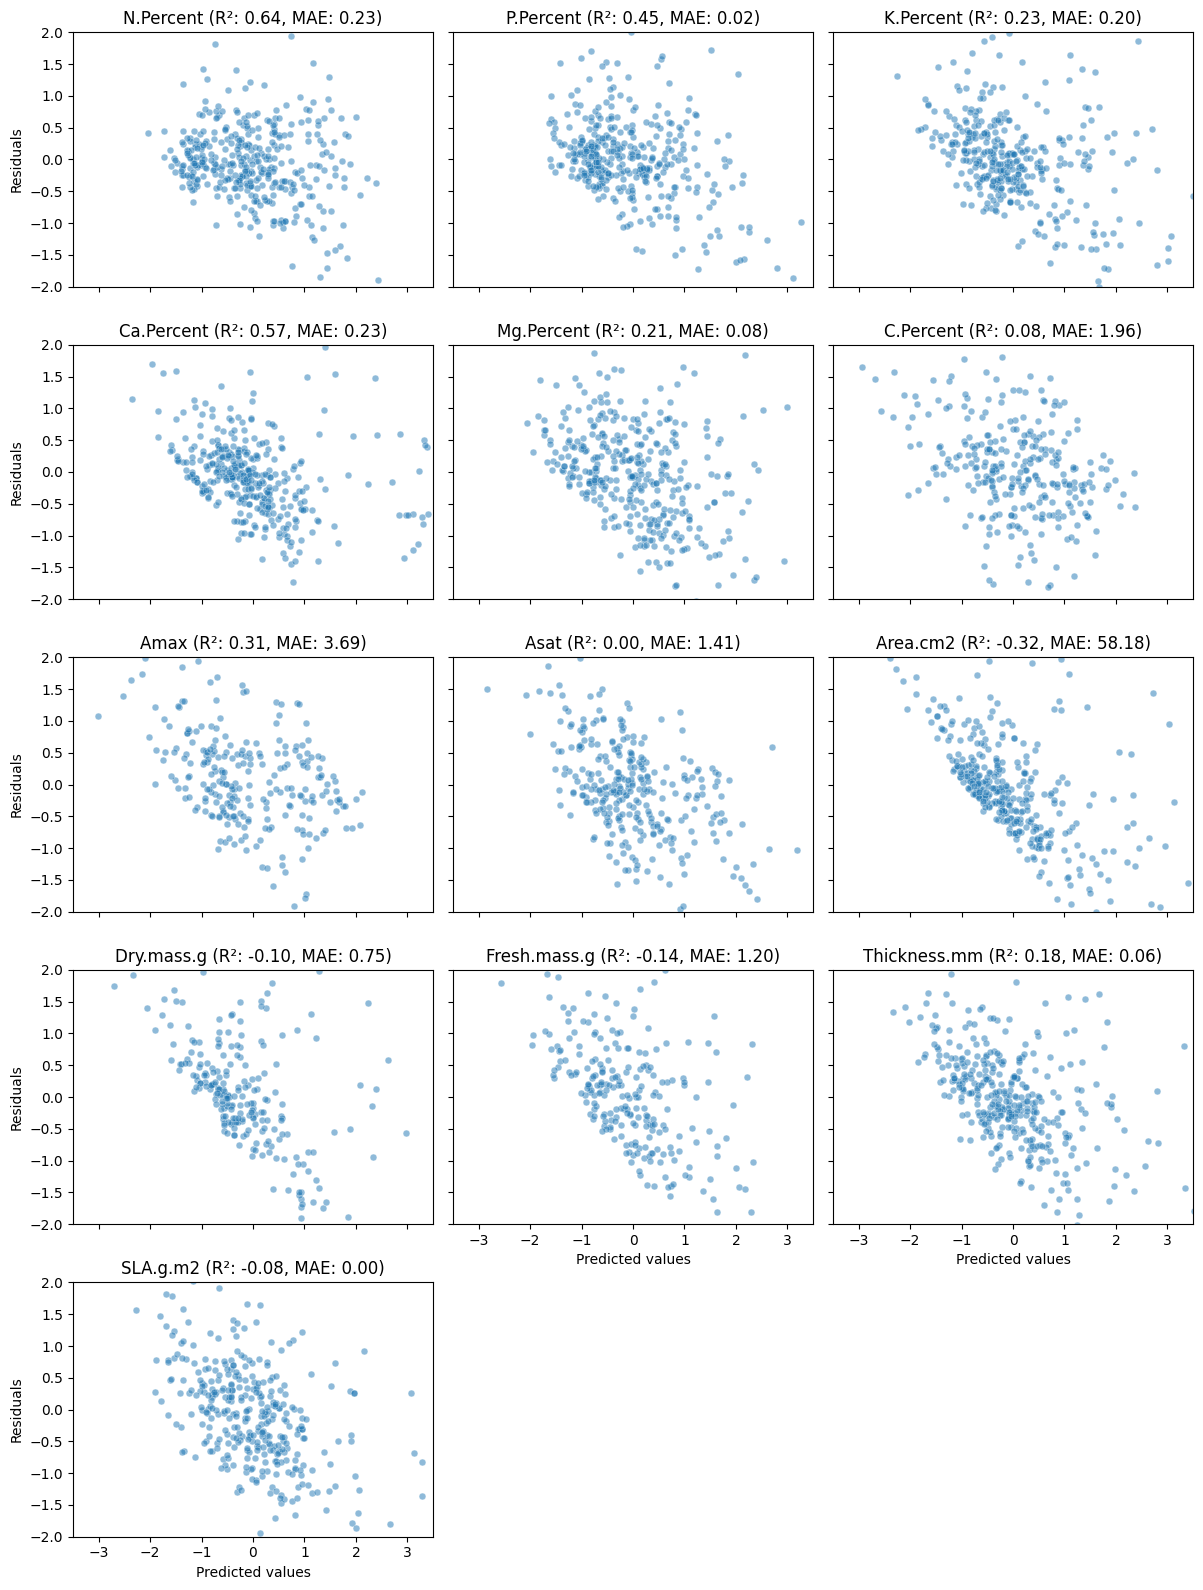

In [54]:
# Plot residuals for each different variable on a single plot
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 16))

# remove empty subplots
for j in range(len(VARS), len(axes.flat)):
    axes.flat[j].remove()

for var in VARS:
    i = VARS.index(var)
    ax = axes.flat[i]
    preds = predictions[var]
    res = residuals[var]
    var_metrics = metrics[var]

    fig = plot_residuals(res, preds, ax, var_metrics, var)

plt.savefig(f"../figures/models/residuals_nnauxvars_2layer_l2reg{l2_reg}.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

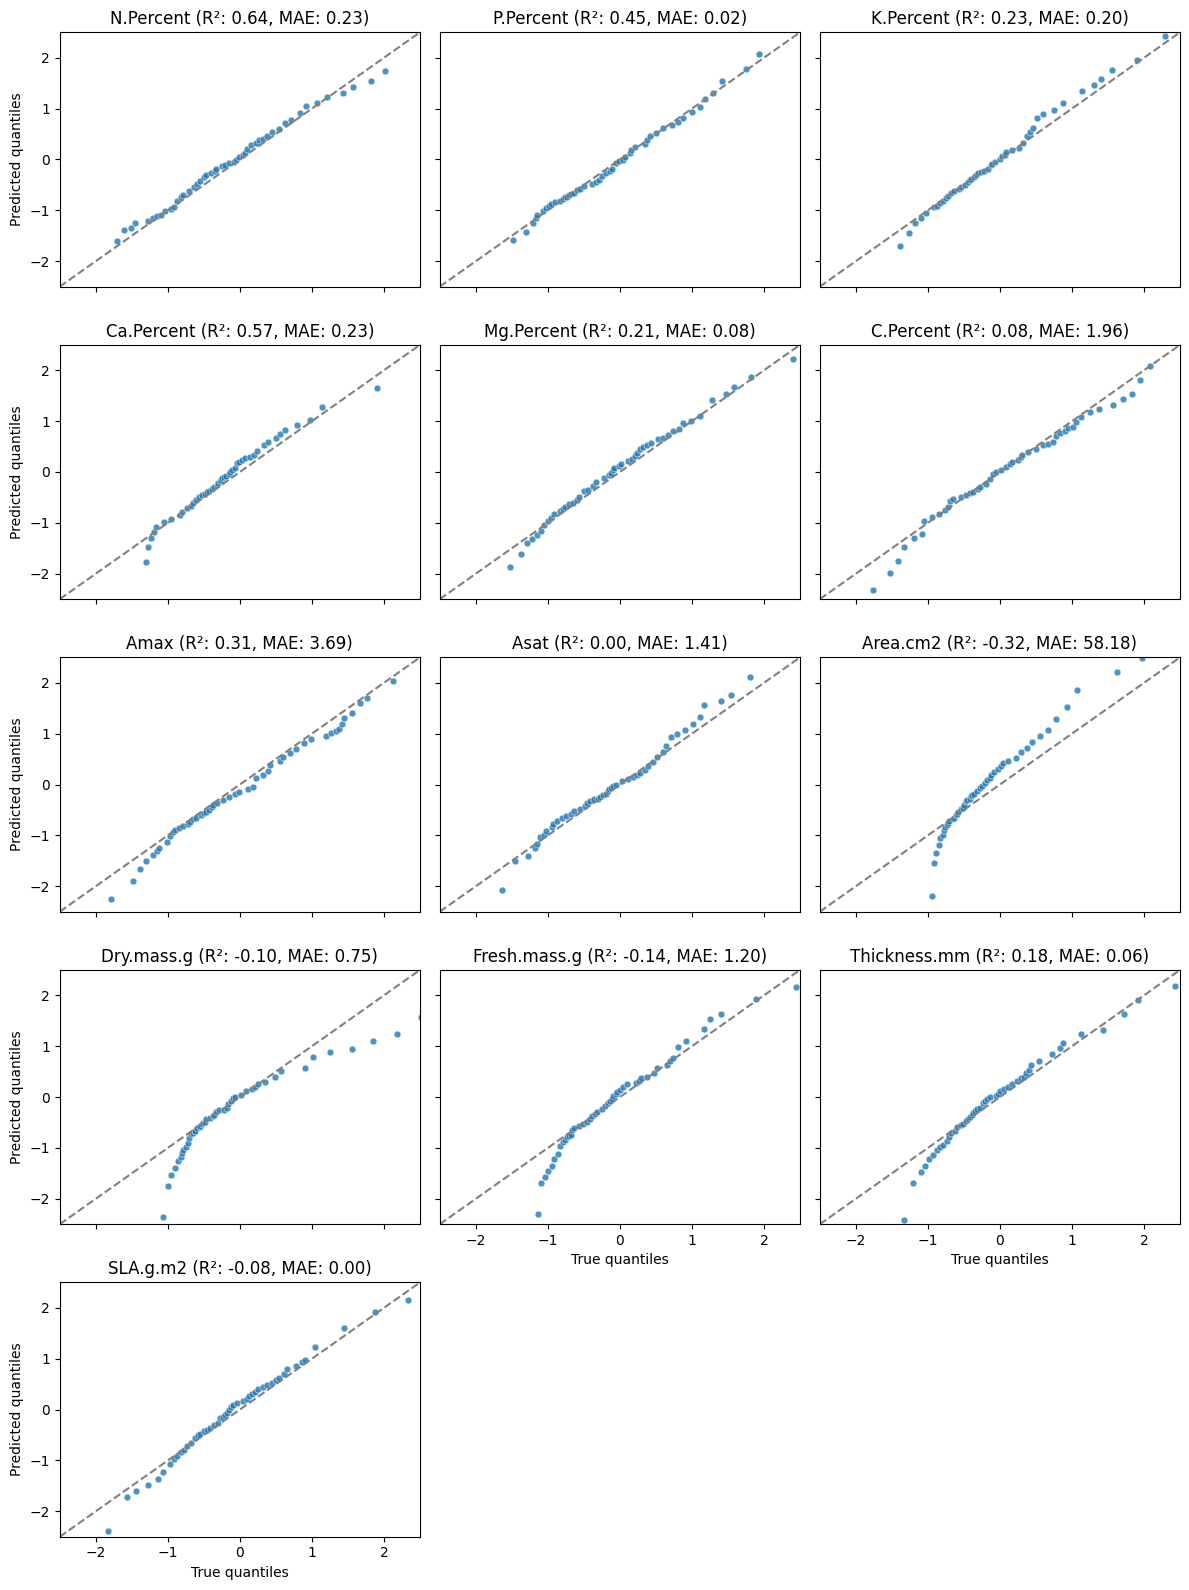

In [55]:
# Plot QQplot for each different variable on a single plot
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 16))

# remove empty subplots
for j in range(len(VARS), len(axes.flat)):
    axes.flat[j].remove()

for var in VARS:
    i = VARS.index(var)
    ax = axes.flat[i]
    preds = predictions[var]
    trues = true_vals[var]
    var_metrics = metrics[var]

    fig = qqplot(trues, preds, ax, var_metrics, var)
    
# Space subplots
plt.subplots_adjust(hspace=0.2, wspace=0.2)

plt.savefig(f"../figures/models/qqplot_nnauxvars_2layer_l2reg{l2_reg}.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()